In [2]:
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import uniform
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from imblearn import over_sampling

In [3]:
def eval_regression(model, pred, xtrain, ytrain, xtest, ytest):
    print("MAE: %.4f" % mean_absolute_error(ytest, pred)) # The MAE
    print("RMSE: %.4f" % mean_squared_error(ytest, pred, squared=False)) # The RMSE
    print('R2 score: %.4f' % r2_score(ytest, pred)) # Explained variance score: 1 is perfect prediction

In [89]:
df = pd.read_excel("影視_top500_revised.xlsx", engine='openpyxl')
df_1 = pd.read_excel("2022_影視_top500_revised.xlsx", engine='openpyxl')

In [90]:
df.head()

,rank,channel_title,video_title,published_time,category,tags,description,view,likes,comments,duration
0,1,The Tonight Show Starring Jimmy Fallon,Tones and I: Dance Monkey (US TV Debut),2019-11-19 20:00:00,23,"['The Tonight Show', 'Jimmy Fallon', 'Tones an...",Music guest Tones and I makes her US TV debut ...,102176941.0,2121432,83661,00:04:08
1,2,The Tonight Show Starring Jimmy Fallon,Musical Genre Challenge with Ariana Grande,2018-05-02 12:15:00,23,"['The Tonight Show', 'Jimmy Fallon', 'Musical ...","Ariana Grande transforms Drake's ""God's Plan"" ...",85008873.0,1677410,52531,00:05:29
2,3,The Tonight Show Starring Jimmy Fallon,Jack Black Performs His Legendary Sax-A-Boom w...,2018-09-21 18:00:00,23,"['The Tonight Show', 'Jimmy Fallon', 'TSJF Int...",Jack Black gives The Tonight Show audience a t...,82980172.0,2149817,38017,00:02:22
3,4,The Tonight Show Starring Jimmy Fallon,"BTS: ""Idol"" | The Tonight Show Starring Jimmy ...",2018-09-26 12:30:00,23,"['The Tonight Show', 'Jimmy Fallon', 'BTS', 'P...",Global phenomenon BTS (?????) delivers a high-...,44400786.0,1243350,44123,00:04:09
4,5,The Tonight Show Starring Jimmy Fallon,BTS and Jimmy Fallon Do the Fortnite Dance Cha...,2018-09-26 11:48:00,23,"['The Tonight Show', 'Jimmy Fallon', 'BTS', 'D...",BTS and Jimmy challenge themselves to mimic th...,33842320.0,1533945,50802,00:02:49


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   rank            1500 non-null   int64         
 1   channel_title   1500 non-null   object        
 2   video_title     1500 non-null   object        
 3   published_time  1500 non-null   datetime64[ns]
 4   category        1500 non-null   int64         
 5   tags            1261 non-null   object        
 6   description     1436 non-null   object        
 7   view            1500 non-null   float64       
 8   likes           1500 non-null   int64         
 9   comments        1500 non-null   int64         
 10  duration        1500 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 129.0+ KB


In [92]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature', 'missing_value']
data_missing_value

,feature,missing_value
0,rank,0
1,channel_title,0
2,video_title,0
3,published_time,0
4,category,0
5,tags,239
6,description,64
7,view,0
8,likes,0
9,comments,0


In [93]:
# refill missing value

df['tags'] = df['tags'].fillna('[]')
df['description'] = df['description'].fillna('')

In [94]:
# check after refill

data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature', 'missing_value']
data_missing_value

,feature,missing_value
0,rank,0
1,channel_title,0
2,video_title,0
3,published_time,0
4,category,0
5,tags,0
6,description,0
7,view,0
8,likes,0
9,comments,0


In [113]:
# get variables

# weighted_score_list = []

# for i in range(len(df['view'])):
#     weighted_score = 0.7*df['view'][i] + 0.15*df['likes'][i] + 0.15*df['comments'][i]
#     weighted_score_list.append(weighted_score)

# df['weighted_score'] = weighted_score_list

df['time_len'] = df['duration'].map(lambda x: 3600 * x.hour + 60 * x.minute + x.second)
df['tags_num'] = df['tags'].map(lambda x: len(str(x).split(',')))
df['title_len'] = df['channel_title'].map(lambda x: len(x))

df_1['time_len'] = df_1['duration'].map(lambda x: 3600 * x.hour + 60 * x.minute + x.second)
df_1['tags_num'] = df_1['tags'].map(lambda x: len(str(x).split(',')))
df_1['title_len'] = df_1['channel_title'].map(lambda x: len(x))

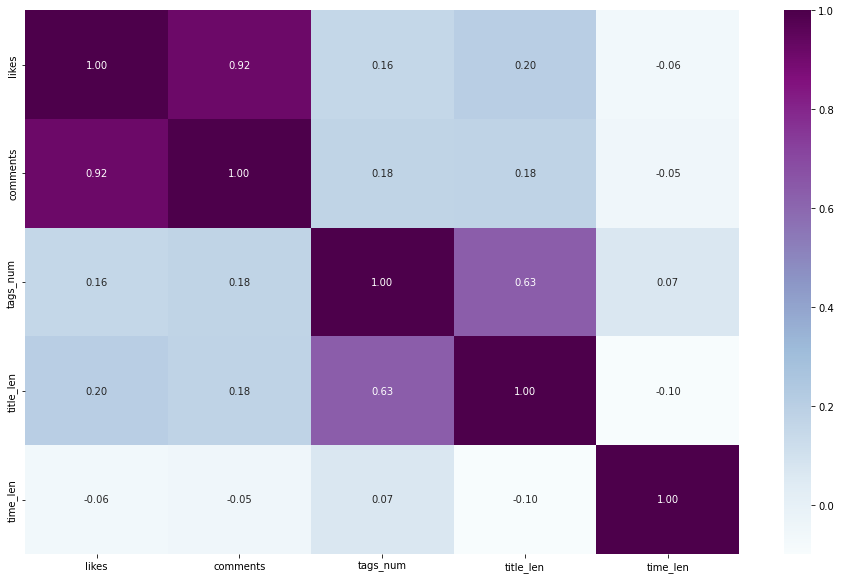

In [114]:
# features

features = ['likes', 'comments','tags_num', 'title_len', 'time_len'] 
corr_= df[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu");

In [115]:
# normalize

numerical_features = ['likes', 'comments','tags_num', 'title_len', 'time_len', 'view'] 

for var in numerical_features:
    df[var] = MinMaxScaler().fit_transform(df[var].values.reshape(len(df), 1))

In [118]:
one_hot_index = [5]
onehotencorder = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), one_hot_index)],
    remainder='passthrough'                     
)

X = df[['likes', 'comments','tags_num', 'title_len', 'time_len', 'category']].values
X = onehotencorder.fit_transform(X)

y = df['weighted_score'].values

In [119]:
category_list = list(np.unique(df['category'].values))

In [120]:
X.shape

(1500, 9)

In [121]:
# split data

# xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

X = df[['likes', 'comments', 'tags_num', 'title_len', 'time_len', 'category']].values
X_1 = df_1[['likes', 'comments', 'tags_num', 'title_len', 'time_len', 'category']].values

y = df['view'].values
y_1 = df_1['view'].values

xtrain = X
ytrain = y
xtest = X_1
ytest = y_1

In [122]:
# simple Linear Regression Model

regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

LinearRegression()

In [123]:
# predict

pred = regressor.predict(xtest)

print('Coefficients: \n', regressor.coef_) # The slope
print('Intercept: \n', regressor.intercept_) # The Intercept

eval_regression(regressor, pred, xtrain, ytrain, xtest, ytest)

Coefficients: 
 [ 7.07239530e-01 -8.12882792e-02  5.65572086e-03 -7.24649072e-04
  2.97814998e-02 -4.52545712e-04]
Intercept: 
 0.016389589014526407
MAE: 1525632.3538
RMSE: 2727485.4588
R2 score: -0.4171


In [124]:
# Fit Ridge Regularization Model

ridge_model = Ridge()
ridge_model.fit(xtrain, ytrain)

Ridge()

In [125]:
# predict

pred = ridge_model.predict(xtest)

print('Coefficients: \n', ridge_model.coef_) # The slope
print('Intercept: \n', ridge_model.intercept_) # The Intercept

eval_regression(ridge_model, pred, xtrain, ytrain, xtest, ytest)

Coefficients: 
 [ 4.84668825e-01  1.37262953e-01  2.68502446e-03  2.45752527e-03
  2.50533370e-02 -4.13831874e-04]
Intercept: 
 0.01632913158123085
MAE: 1533898.3708
RMSE: 2739829.2558
R2 score: -0.4299


In [126]:
# Randomized Search

alpha = [200, 230, 250,265, 270, 275, 290, 300, 500] # alpha # ??????
hyperparameters = dict(alpha=alpha)

ridge_model = Ridge()
clf = GridSearchCV(ridge_model, hyperparameters, cv=5, scoring='r2')

# Fitting Model
best_model = clf.fit(xtrain, ytrain)

In [127]:
# predict

pred = best_model.predict(xtest)
eval_regression(best_model, pred, xtrain, ytrain, xtest, ytest)

MAE: 1551457.1392
RMSE: 2766039.2751
R2 score: -0.4574


In [128]:
# Fit Lasso Regularization Model

lasso_model = Lasso()
lasso_model.fit(xtrain, ytrain)

Lasso()

In [129]:
# predict

pred = lasso_model.predict(xtest)
eval_regression(lasso_model, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552547.2483
RMSE: 2767671.1416
R2 score: -0.4592


In [130]:
# randomize search

alpha = [0.02, 0.024, 0.025, 0.026, 0.03] # alpha or lambda

hyperparameters = dict(alpha=alpha)

lasso_model = Lasso()
clf = GridSearchCV(lasso_model, hyperparameters, cv=5, scoring='r2')

#Fitting Model
best_model = clf.fit(xtrain, ytrain)

In [131]:
# predict

pred = best_model.predict(xtest)
eval_regression(best_model, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552547.2483
RMSE: 2767671.1416
R2 score: -0.4592


In [132]:
# Fit Elastic Net Regularization Model

elasticnet_model = ElasticNet()
elasticnet_model.fit(xtrain, ytrain)

ElasticNet()

In [133]:
# predict

pred = elasticnet_model.predict(xtest)
eval_regression(elasticnet_model, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552547.2483
RMSE: 2767671.1416
R2 score: -0.4592


In [134]:
# Fit Decision Tree Model

dt = DecisionTreeRegressor()
dt.fit(xtrain, ytrain)
pred = dt.predict(xtest)
eval_regression(dt, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552546.8797
RMSE: 2767670.9397
R2 score: -0.4592


In [143]:
# Fit Random Forest Model

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(xtrain, ytrain)
pred = rf.predict(xtest)
eval_regression(rf, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552546.8163
RMSE: 2767670.9128
R2 score: -0.4592


In [144]:
rf.feature_importances_

array([0.68329822, 0.12032392, 0.06252224, 0.0213041 , 0.10688803,
       0.00566349])

In [145]:
X

array([[8.30152058e-01, 7.94048975e-01, 5.00000000e-01, 9.47368421e-01,
        5.75811209e-03, 2.30000000e+01],
       [6.56398774e-01, 4.98585801e-01, 5.52631579e-01, 9.47368421e-01,
        7.66961652e-03, 2.30000000e+01],
       [8.41259586e-01, 3.60829537e-01, 4.73684211e-01, 9.47368421e-01,
        3.25663717e-03, 2.30000000e+01],
       ...,
       [2.04149993e-03, 7.34624146e-03, 3.81578947e-01, 1.84210526e-01,
        1.34041298e-02, 1.00000000e+00],
       [2.42812097e-03, 1.12566439e-02, 5.26315789e-01, 9.47368421e-01,
        6.25368732e-03, 2.30000000e+01],
       [2.43712125e-03, 4.10971906e-03, 3.94736842e-01, 2.10526316e-01,
        1.69911504e-03, 1.00000000e+00]])

In [146]:
# feature importance graph

feature_list = ['likes', 'comments', 'time_len', 'tags_num', 'title_len'] + category_list
feat_importances = pd.Series(rf.feature_importances_, index=feature_list)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

ValueError: Length of values (6) does not match length of index (9)

In [142]:
# Fit Support Vector Regressor Model

svr = SVR()
svr.fit(xtrain, ytrain)
pred = svr.predict(xtest)
eval_regression(svr, pred, xtrain, ytrain, xtest, ytest)

MAE: 1552547.1601
RMSE: 2767671.0920
R2 score: -0.4592
